# Integration with PHOEBE

In [1]:
import phoebe
from spice.models.binary import PhoebeBinary
from spice.models.phoebe_utils import PhoebeConfig
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
from spice.spectrum import simulate_observed_flux
from transformer_payne import Blackbody
from phoebe.parameters.dataset import _mesh_columns
%matplotlib inline

from jax import config
import jax
config.update('jax_platform_name', 'cpu')

## PHOEBE Configuration and Binary System Setup

In this section, we set up a binary system using PHOEBE and prepare it for integration with SPICE.

We configure the binary system with default parameters, add datasets for mesh, orbit, and light curve.

To make the lightcurve comparision as close as possible, we are going to use a simple blackbody spectrum model and disable limb darkening manually.

1. Create a default binary system
2. Define time points for computation
3. Add mesh, orbit, and light curve datasets
4. Configure limb darkening and atmosphere models
5. Run initial computation


In [45]:
b = phoebe.default_binary()

# Time points are in days
times = np.linspace(0, 1, 100)

# Use all columns for the mesh dataset
COLUMNS = _mesh_columns
b.add_dataset('mesh', times=times, columns=COLUMNS, dataset='mesh01')
b.add_dataset('orb', compute_times=times, dataset='orb01')
b.set_value_all('period@binary@component', 1.0)
b.add_dataset('lc', compute_times=times, passband='Johnson:V', dataset='lc01')
b.set_value_all('incl@binary', 0.0)

# Disable irradiation and finite light travel time effects
b.run_compute(irrad_method='none', coordinates='uvw', ltte=False)

100%|██████████| 100/100 [00:02<00:00, 45.22it/s]


KeyboardInterrupt: 

In [24]:
import jax.numpy as jnp
from spice.models.orbit_utils import get_orbit_jax
# def get_orbit_jax(time, m1, m2, P, ecc, T, i, omega, Omega) -> ArrayLike:

orbit = get_orbit_jax(jnp.linspace(0, 1, 100), 1., 1., 1., 0., 0., 0., 0., 0.)

In [25]:
orbit.shape

(6, 3, 10)

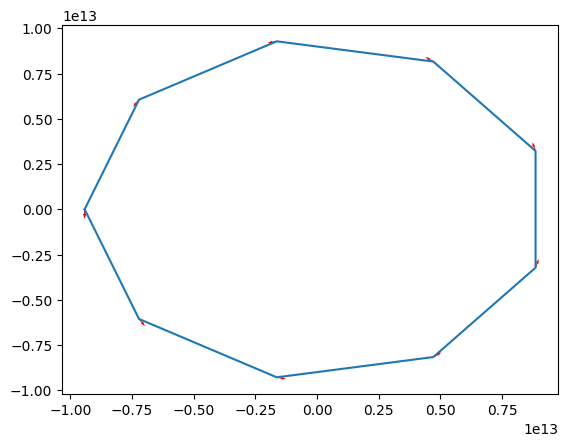

In [26]:
plt.plot(orbit[2, 0, :], orbit[2, 1, :])
plt.quiver(orbit[2, 0, :], orbit[2, 1, :], orbit[3, 0, :], orbit[3, 1, :], color='r', scale=1e5, width=0.002)

#plt.plot(orbit[4, 0, :], orbit[4, 1, :])

In [27]:
from spice.models.binary import Binary, add_orbit, evaluate_orbit_at_times, evaluate_orbit
from spice.models.mesh_model import IcosphereModel
from spice.models.mesh_view import get_mesh_view
import matplotlib.pyplot as plt
import numpy as np
from spice.spectrum import simulate_observed_flux
from transformer_payne import Blackbody
import jax.numpy as jnp
%matplotlib inline

def default_icosphere():
    return get_mesh_view(IcosphereModel.construct(1000, 1., 1., [5700, 0.], ['teff', 'abun']), jnp.array([0., 1., 0.]))

body1 = default_icosphere()
body2 = default_icosphere()
binary = Binary.from_bodies(body1, body2)
binary = add_orbit(binary, 0.0027378507871321013, 0., 0., 0., 0., 0., 10)
times = jnp.linspace(0, 0.0027378507871321013, 10)
pb1, pb2 = evaluate_orbit_at_times(binary, times)

/Users/mjablons/Documents/stellar-mesh-integration/src/spice/models/mesh_model.py:233: UserWarning: If override_log_g is True, either parameter_names must include one of [logg,loggs,log_g,log_gs,log g,log gs,surface gravity,surface gravities,surface_gravity,surface_gravities], or log_g_index must be passed for log g to be used in the spectrum emulator.
  warnings.warn(f"If override_log_g is True, either parameter_names must include one of [" + ",".join(
/Users/mjablons/Documents/stellar-mesh-integration/src/spice/models/mesh_model.py:233: UserWarning: If override_log_g is True, either parameter_names must include one of [logg,loggs,log_g,log_gs,log g,log gs,surface gravity,surface gravities,surface_gravity,surface_gravities], or log_g_index must be passed for log g to be used in the spectrum emulator.
  warnings.warn(f"If override_log_g is True, either parameter_names must include one of [" + ",".join(


Let's use the simplest blackbody model.

We pass the parameter_values dict to PhoebeBinary.construct to initialize the binary system with specific parameters - since PHOEBE doesn't contain all of the parameters that can be used by the emulator, we need to add our own parameters to the mesh model. In the case of the blackbody model, this is not needed, as PHOEBE does contain temperature, but we'd need this line for e.g. abundances.


In [29]:
bb = Blackbody()

p1 = PhoebeConfig(b, 'mesh01', 'orb01')
pb = PhoebeBinary.construct(p1, bb.parameter_names, parameter_values={pn: sp for pn, sp in zip(bb.parameter_names, bb.solar_parameters)})

In [35]:
pb.P, pb.ecc, pb.T, pb.i, pb.omega, pb.Omega

(0.0027378507871321013, 0.0, 0.0, 0.0, 0.0, 0.0)

In [42]:
pb.body1_velocities

array([[-1.34070739e+02,  8.20946507e-15,  0.00000000e+00],
       [-1.02704145e+02, -8.61790098e+01,  0.00000000e+00],
       [-2.32811395e+01, -1.32033903e+02,  0.00000000e+00],
       [ 6.70353695e+01, -1.16108666e+02,  0.00000000e+00],
       [ 1.25985284e+02, -4.58548934e+01,  0.00000000e+00],
       [ 1.25985284e+02,  4.58548934e+01,  0.00000000e+00],
       [ 6.70353695e+01,  1.16108666e+02,  0.00000000e+00],
       [-2.32811395e+01,  1.32033903e+02,  0.00000000e+00],
       [-1.02704145e+02,  8.61790098e+01,  0.00000000e+00],
       [-1.34070739e+02,  3.79791493e-14,  0.00000000e+00]])

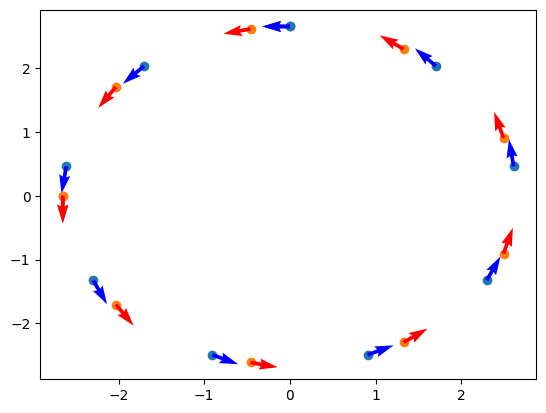

In [44]:
plt.scatter(pb.body1_centers[:, 0], pb.body1_centers[:, 1])
plt.quiver(pb.body1_centers[:, 0], pb.body1_centers[:, 1], 
           pb.body1_velocities[:, 0], pb.body1_velocities[:, 1],
           color='b', label='Primary velocities')

plt.scatter([_pb1.center[0] for _pb1 in pb1], [_pb1.center[1] for _pb1 in pb1])
plt.quiver([_pb1.center[0] for _pb1 in pb1], [_pb1.center[1] for _pb1 in pb1], 
           [_pb1.orbital_velocity[0] for _pb1 in pb1], [_pb1.orbital_velocity[1] for _pb1 in pb1],
           color='r', label='Primary velocities')

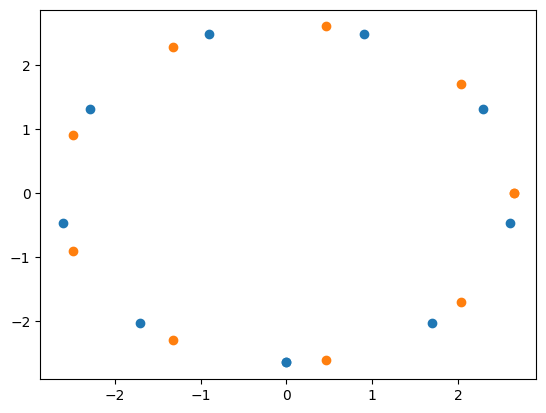

In [34]:
plt.scatter(pb.body2_centers[:, 0], pb.body2_centers[:, 1])
plt.scatter([_pb1.center[0] for _pb1 in pb2], [_pb1.center[1] for _pb1 in pb2])

In [39]:
pb2[0].orbital_velocity, pb.body2_velocities[0]

(Array([-4.0503647e-03,  1.3412177e+04,  0.0000000e+00], dtype=float32),
 array([ 1.34070739e+02, -2.46283952e-14,  0.00000000e+00]))

Let's evaluate the orbit to create arrays of meshes with calculated parameters.

In [4]:
from spice.models.binary import evaluate_orbit_at_times

pb1, pb2 = evaluate_orbit_at_times(pb, times)

In [33]:
pb1[0].orbital_velocity

array([-1.34070739e+02,  5.02684756e-31, -8.20946507e-15])

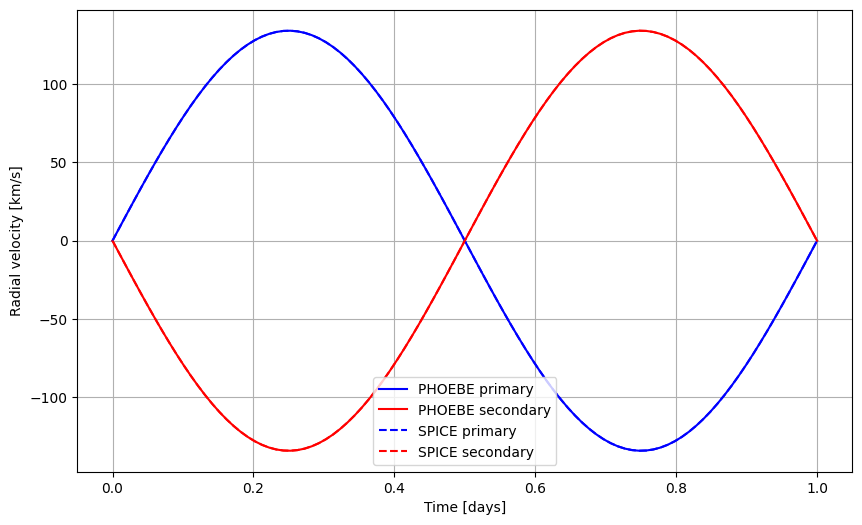

In [38]:
# Get velocities from PHOEBE
phoebe_vels1 = b.get_parameter('vws@primary@orb01@model').value
phoebe_vels2 = b.get_parameter('vws@secondary@orb01@model').value

# Get velocities from SPICE
# spice_vels1 = pb.body1_velocities[:, 2] #/ 1e5 # Convert from cm/s to km/s
# spice_vels2 = pb.body2_velocities[:, 2] #/ 1e5
spice_vels1 = [_pb1.orbital_velocity[2] for _pb1 in pb1]
spice_vels2 = [_pb2.orbital_velocity[2] for _pb2 in pb2]

plt.figure(figsize=(10,6))
plt.plot(times, phoebe_vels1, 'b-', label='PHOEBE primary')
plt.plot(times, phoebe_vels2, 'r-', label='PHOEBE secondary') 
plt.plot(times, spice_vels1, 'b--', label='SPICE primary')
plt.plot(times, spice_vels2, 'r--', label='SPICE secondary')
plt.xlabel('Time [days]')
plt.ylabel('Radial velocity [km/s]')
plt.legend()
plt.grid(True)


## Synthetic photometry

Let's calculate the observed flux (for the default value of $d=10$ pc) for both components. Note that we can **disable the Doppler shift**, which can be useful for comparisions with PHOEBE, as it doesn't include this effect because of computational concerns. (https://phoebe-project.org/docs/latest/tutorials/beaming_boosting)

In [3]:
ws = np.linspace(900, 40000, 1000)
s1s = [simulate_observed_flux(bb.intensity, _pb1, np.log10(ws), disable_doppler_shift=False) for _pb1 in pb1]
s2s = [simulate_observed_flux(bb.intensity, _pb2, np.log10(ws), disable_doppler_shift=False) for _pb2 in pb2]

s1s_no_d = [simulate_observed_flux(bb.intensity, _pb1, np.log10(ws), disable_doppler_shift=True) for _pb1 in pb1]
s2s_no_d = [simulate_observed_flux(bb.intensity, _pb2, np.log10(ws), disable_doppler_shift=True) for _pb2 in pb2]

NameError: name 'pb1' is not defined

Calculate the magnitude differences for the PHOEBE lightcurve.

In [6]:
diffs_phoebe = -2.5*np.log10(b.get_parameter('fluxes@lc01@model').value)

In [7]:
from spice.spectrum import AB_passband_luminosity
from spice.spectrum.filter import JohnsonV

johnsonV = JohnsonV()
lums = [AB_passband_luminosity(johnsonV, ws, s1[:, 0]+s2[:, 0]) for s1, s2 in zip(s1s, s2s)]
lums_no_d = [AB_passband_luminosity(johnsonV, ws, s1[:, 0]+s2[:, 0]) for s1, s2 in zip(s1s_no_d, s2s_no_d)]

Let's see the impact of Doppler shift on this system.

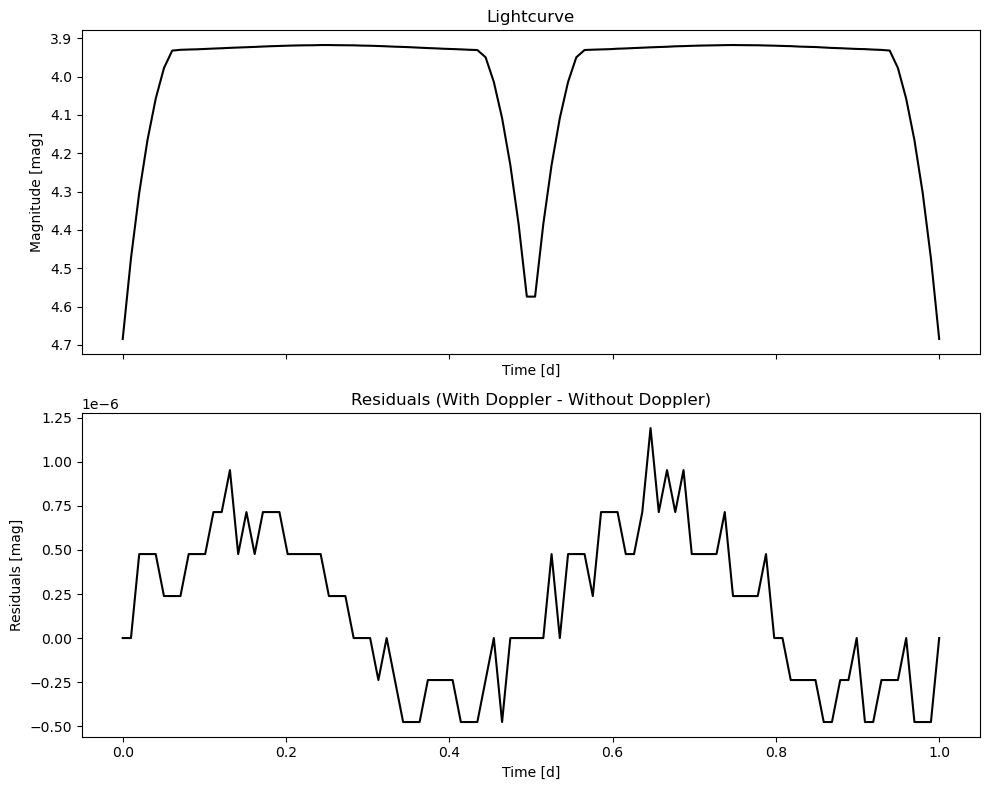

In [8]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# Plot lightcurves
ax1.plot(times, lums, color='black')
ax1.invert_yaxis()
ax1.set_ylabel('Magnitude [mag]')
ax1.set_xlabel('Time [d]')
ax1.set_title('Lightcurve')

# Plot residuals
residuals = np.array(lums) - np.array(lums_no_d)
ax2.plot(times, residuals, color='black')
ax2.set_ylabel('Residuals [mag]')
ax2.set_xlabel('Time [d]')
ax2.set_title('Residuals (With Doppler - Without Doppler)')

plt.tight_layout()
plt.show()

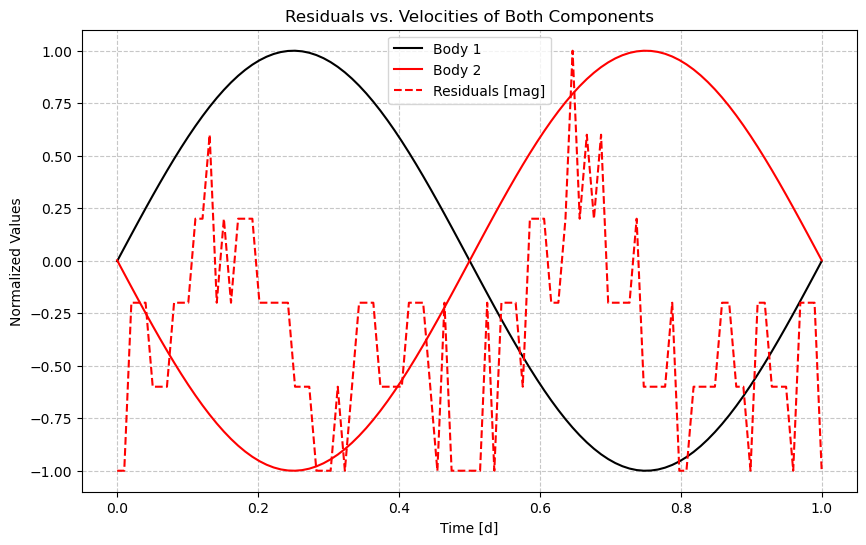

In [9]:
residuals = np.abs(np.array(lums) - np.array(lums_no_d))
vels1 = [np.mean(_pb1.los_velocities) for _pb1 in pb1]
vels2 = [np.mean(_pb2.los_velocities) for _pb2 in pb2]

plt.figure(figsize=(10, 6))
# Normalize velocities to -1, 1 range
vels1_norm = 2 * (np.array(vels1) - np.min(vels1)) / (np.max(vels1) - np.min(vels1)) - 1
vels2_norm = 2 * (np.array(vels2) - np.min(vels2)) / (np.max(vels2) - np.min(vels2)) - 1

# Plot normalized velocities for both components
plt.plot(times, vels1_norm, color='black', label='Body 1')
plt.plot(times, vels2_norm, color='red', label='Body 2')
# Normalize residuals to -1, 1 range
residuals_norm = 2 * (residuals - np.min(residuals)) / (np.max(residuals) - np.min(residuals)) - 1

# Plot normalized residuals
plt.plot(times, residuals_norm, label='Residuals [mag]', color='red', linestyle='--')

plt.xlabel('Time [d]')
plt.ylabel('Normalized Values')

plt.title('Residuals vs. Velocities of Both Components')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

We can see that in the case of this system, the Doppler shift shouldn't be that significant. Let's compare PHOEBE and SPICE lightcurves.

In [10]:
# We only care about the change in magnitudes, so we can subtract the first value

diffs_phoebe = diffs_phoebe-diffs_phoebe[0]
diffs_spice = np.array(lums_no_d)-lums_no_d[0]

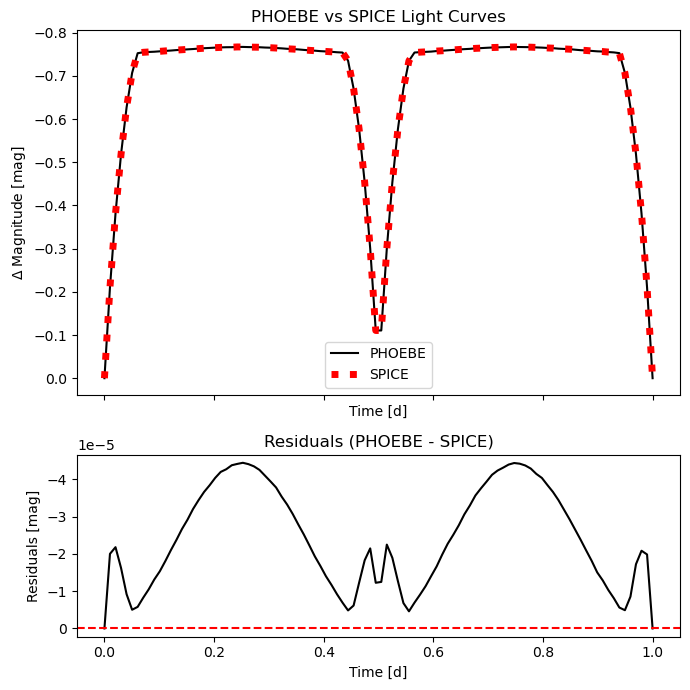

In [11]:
# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(7, 7), sharex=True, gridspec_kw={'height_ratios': [2, 1]})

# Plot PHOEBE and SPICE data on the first subplot
ax1.plot(times, diffs_phoebe, color='black', label='PHOEBE')
ax1.plot(times, diffs_spice, color='red', linestyle='dotted', linewidth=5., label='SPICE')
ax1.invert_yaxis()
ax1.legend()
ax1.set_xlabel('Time [d]')
ax1.set_ylabel('$\Delta$ Magnitude [mag]')
ax1.set_title('PHOEBE vs SPICE Light Curves')

# Calculate and plot residuals on the second subplot
residuals = diffs_phoebe - diffs_spice
ax2.plot(times, residuals, color='black')
ax2.axhline(y=0, color='r', linestyle='--')  # Add a horizontal line at y=0
ax2.invert_yaxis()
ax2.set_xlabel('Time [d]')
ax2.set_ylabel('Residuals [mag]')
ax2.set_title('Residuals (PHOEBE - SPICE)')

plt.tight_layout()
plt.show()